In [21]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

In [61]:
# Initialize wandb
wandb.login()
wandb.init(project='assignment-1', entity="ishaan_maheshwari-indian-institute-of-technology-madras" )

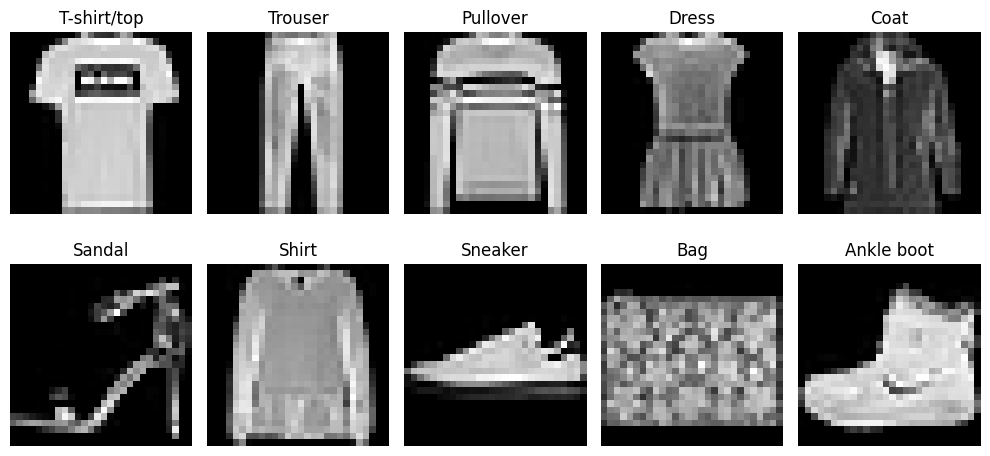

In [3]:
# Load the dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Fashion-MNIST class labels
class_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Find one example per class
unique_classes = np.unique(y_train)
sample_images = []
sample_labels = []

for cls in unique_classes:
    idx = np.where(y_train == cls)[0][0]  # Get the first occurrence
    sample_images.append(X_train[idx])
    sample_labels.append(class_labels[cls])

# Plot images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(sample_images[i], cmap='gray')
    ax.set_title(sample_labels[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

# Log images to wandb
wandb.log({"Sample Images": [wandb.Image(img, caption=label) for img, label in zip(sample_images, sample_labels)]})

# Finish wandb run
wandb.finish()

### Pre-Processing

In [24]:
from sklearn.model_selection import train_test_split 

# Load dataset and train the model
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

# Normalize and flatten images
X_train, X_val, X_test = X_train.reshape(-1, 784) / 255.0, X_val.reshape(-1, 784) / 255.0, X_test.reshape(-1, 784) / 255.0
y_train, y_val, y_test = np.eye(10)[y_train], np.eye(10)[y_val], np.eye(10)[y_test]

In [5]:
unique, counts = np.unique(np.argmax(y_train, axis=1), return_counts=True)
print(dict(zip(unique, counts)))  # Check class distribution

{np.int64(0): np.int64(5385), np.int64(1): np.int64(5404), np.int64(2): np.int64(5383), np.int64(3): np.int64(5419), np.int64(4): np.int64(5385), np.int64(5): np.int64(5404), np.int64(6): np.int64(5351), np.int64(7): np.int64(5435), np.int64(8): np.int64(5402), np.int64(9): np.int64(5432)}


In [6]:
import numpy as np

# Activation Functions and Derivatives
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x) ** 2

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

# Softmax Function for Output Layer
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Avoid overflow
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Weight Initialization Functions
def random_init(shape):
    return np.random.randn(*shape) * 0.01

def xavier_init(shape):
    return np.random.randn(*shape) * np.sqrt(1 / shape[0])

class FeedforwardNN:
    def __init__(self, input_size, hidden_layers, hidden_neurons, output_size, 
                 activation='relu', weight_init='random'):
        """
        input_size: Number of input neurons (784 for Fashion-MNIST)
        hidden_layers: Number of hidden layers
        hidden_neurons: Number of neurons in each hidden layer
        output_size: Number of output classes (10 for Fashion-MNIST)
        activation: Activation function for hidden layers (relu, sigmoid, tanh)
        weight_init: Weight initialization (random, xavier)
        """
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.hidden_neurons = hidden_neurons
        self.output_size = output_size

        # Select activation function
        if activation == 'relu':
            self.activation = relu
            self.activation_derivative = relu_derivative
        elif activation == 'sigmoid':
            self.activation = sigmoid
            self.activation_derivative = sigmoid_derivative
        elif activation == 'tanh':
            self.activation = tanh
            self.activation_derivative = tanh_derivative
        else:
            raise ValueError("Invalid activation function")

        # Select weight initialization function
        self.weight_init = xavier_init if weight_init == 'xavier' else random_init

        # Initialize weights and biases
        self.weights = []
        self.biases = []
        
        # Input to first hidden layer
        self.weights.append(self.weight_init((input_size, hidden_neurons)))
        self.biases.append(np.zeros((1, hidden_neurons)))
        
        # Hidden layers
        for _ in range(hidden_layers - 1):
            self.weights.append(self.weight_init((hidden_neurons, hidden_neurons)))
            self.biases.append(np.zeros((1, hidden_neurons)))
        
        # Last hidden layer to output layer
        self.weights.append(self.weight_init((hidden_neurons, output_size)))
        self.biases.append(np.zeros((1, output_size)))

    def forward(self, X):
        """
        Performs forward propagation
        Returns the activations and raw outputs of each layer
        """
        activations = [X]
        raw_outputs = []

        # Forward pass through hidden layers
        for i in range(self.hidden_layers):
            raw_output = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            activated_output = self.activation(raw_output)
            raw_outputs.append(raw_output)
            activations.append(activated_output)
        
        # Output layer with softmax
        raw_output = np.dot(activations[-1], self.weights[-1]) + self.biases[-1]
        activated_output = softmax(raw_output)
        raw_outputs.append(raw_output)
        activations.append(activated_output)

        return activations, raw_outputs

In [7]:
# Example Usage:
nn = FeedforwardNN(input_size=784, hidden_layers=3, hidden_neurons=64, output_size=10, 
                   activation='relu', weight_init='xavier')

sample_input = np.random.randn(1, 784)  # Fake input (1 sample)
activations, raw_outputs = nn.forward(sample_input)

print("Final Output (Softmax Probabilities):", activations[-1])

Final Output (Softmax Probabilities): [[0.10328949 0.13619696 0.06584636 0.09880742 0.12471476 0.10583732
  0.07940521 0.03935013 0.1533485  0.09320387]]


In [29]:
import numpy as np

class NeuralNetwork:
    def __init__(self, input_size, hidden_layers, hidden_neurons, output_size, 
                 activation='relu', weight_init='random', optimizer='sgd', 
                 learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8,
                 l2_reg=0.0):
        """
        - input_size: Number of input neurons (784 for Fashion-MNIST)
        - hidden_layers: Number of hidden layers
        - hidden_neurons: Number of neurons per hidden layer
        - output_size: Number of output classes (10 for Fashion-MNIST)
        - activation: Activation function ('relu', 'sigmoid', 'tanh')
        - weight_init: Weight initialization ('random', 'xavier')
        - optimizer: Optimizer to use ('sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam')
        - learning_rate: Learning rate
        - beta1, beta2: Momentum terms (used in momentum-based methods)
        - epsilon: Small constant for numerical stability
        - l2_reg: L2 Regularization factor (Weight Decay)
        """
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.hidden_neurons = hidden_neurons
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.optimizer = optimizer
        self.l2_reg = l2_reg
    
        # Activation function selection
        self.activations = {'relu': relu, 'sigmoid': sigmoid, 'tanh': tanh}
        self.activation_derivatives = {'relu': relu_derivative, 'sigmoid': sigmoid_derivative, 'tanh': tanh_derivative}
        self.activation = self.activations.get(activation, relu)
        self.activation_derivative = self.activation_derivatives.get(activation, relu_derivative)
    
        # Weight initialization
        self.weight_init_func = xavier_init if weight_init == 'xavier' else random_init
        self.weights = []
        self.biases = []
        
        # Initialize weights & biases
        self._initialize_weights()
    
        # Initialize optimizer-specific variables
        self.velocity_w = [np.zeros_like(w) for w in self.weights]  # For momentum, NAG
        self.velocity_b = [np.zeros_like(b) for b in self.biases]
        self.squared_grad_w = [np.zeros_like(w) for w in self.weights]  # For RMSprop, Adam, Nadam
        self.squared_grad_b = [np.zeros_like(b) for b in self.biases]
        self.m_w = [np.zeros_like(w) for w in self.weights]  # Adam/Nadam first moment
        self.m_b = [np.zeros_like(b) for b in self.biases]
        self.t = 1  # Time step for Adam/Nadam


    def _initialize_weights(self):
        """ Initialize weights and biases """
        self.weights.append(self.weight_init_func((self.input_size, self.hidden_neurons)))
        self.biases.append(np.zeros((1, self.hidden_neurons)))
        for _ in range(self.hidden_layers - 1):
            self.weights.append(self.weight_init_func((self.hidden_neurons, self.hidden_neurons)))
            self.biases.append(np.zeros((1, self.hidden_neurons)))
        self.weights.append(self.weight_init_func((self.hidden_neurons, self.output_size)))
        self.biases.append(np.zeros((1, self.output_size)))

    def forward(self, X):
        """ Forward propagation """
        activations = [X]
        raw_outputs = []
        for i in range(self.hidden_layers):
            raw_output = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            activated_output = self.activation(raw_output)
            raw_outputs.append(raw_output)
            activations.append(activated_output)
        raw_output = np.dot(activations[-1], self.weights[-1]) + self.biases[-1]
        activated_output = softmax(raw_output)
        raw_outputs.append(raw_output)
        activations.append(activated_output)
        return activations, raw_outputs

    def backward(self, X, y_true, activations, raw_outputs):
        """ Backpropagation with L2 regularization """
        gradients_w = [np.zeros_like(w) for w in self.weights]
        gradients_b = [np.zeros_like(b) for b in self.biases]
    
        # Compute error at output layer
        y_pred = activations[-1]
        error = y_pred - y_true  # Softmax cross-entropy derivative
    
        # Backpropagate through layers
        for i in reversed(range(self.hidden_layers + 1)):
            gradients_w[i] = (np.dot(activations[i].T, error) / X.shape[0]) + (self.l2_reg * self.weights[i] / X.shape[0])
            gradients_b[i] = np.sum(error, axis=0, keepdims=True) / X.shape[0]
    
            if i > 0:
                error = np.dot(error, self.weights[i].T) * self.activation_derivative(activations[i])
    
        return gradients_w, gradients_b

    def update_weights(self, gradients_w, gradients_b):
        """ Update weights using the selected optimizer """
        if self.optimizer == 'sgd':
            self._sgd_update(gradients_w, gradients_b)
        elif self.optimizer == 'momentum':
            self._momentum_update(gradients_w, gradients_b)
        elif self.optimizer == 'nesterov':
            self._nesterov_update(gradients_w, gradients_b)
        elif self.optimizer == 'rmsprop':
            self._rmsprop_update(gradients_w, gradients_b)
        elif self.optimizer == 'adam':
            self._adam_update(gradients_w, gradients_b)
        elif self.optimizer == 'nadam':
            self._nadam_update(gradients_w, gradients_b)

    def evaluate(self, X, y_true):
        """ Evaluate the model on a given dataset """
        activations, _ = self.forward(X)  # Forward pass
        y_pred = activations[-1]  # Get softmax output
    
        # Compute loss (cross-entropy)
        loss = -np.mean(np.sum(y_true * np.log(y_pred + 1e-8), axis=1))  
    
        # Compute accuracy
        y_pred_labels = np.argmax(y_pred, axis=1)
        y_true_labels = np.argmax(y_true, axis=1)
        accuracy = np.mean(y_pred_labels == y_true_labels)
    
        return loss, accuracy

    def predict(self, X):
        """ Generate predictions for input X """
        activations, _ = self.forward(X)  # Forward pass
        return activations[-1]  # Return softmax probabilities

    def train(self, X_train, y_train, batch_size):
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            
            # Forward and backward pass
            activations, raw_outputs = self.forward(X_batch)
            gradients_w, gradients_b = self.backward(X_batch, y_batch, activations, raw_outputs)
            
            # Update weights
            self.update_weights(gradients_w, gradients_b)
        
        # Evaluate training loss and accuracy
        train_loss, train_acc = self.evaluate(X_train, y_train)
        return train_loss, train_acc
    
    def train_with_epochs(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        for epoch in range(epochs):
            # Implement batch-wise training
            for i in range(0, len(X_train), batch_size):
                X_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                
                # Forward and backward pass
                activations, raw_outputs = self.forward(X_batch)
                gradients_w, gradients_b = self.backward(X_batch, y_batch, activations, raw_outputs)
                
                # Update weights
                self.update_weights(gradients_w, gradients_b)
            
            # Evaluate after epoch
            val_loss, val_acc = self.evaluate(X_val, y_val)
            wandb.log({"epoch": epoch, "val_loss": val_loss, "val_acc": val_acc})

    def test(self, X_test, y_test):
        """ Evaluate the model on a given dataset """
        activations, _ = self.forward(X_test)  # Forward pass
        y_pred = activations[-1]  # Get softmax output 
    
        # Compute accuracy
        y_pred_labels = np.argmax(y_pred, axis=1)
        y_true_labels = np.argmax(y_test, axis=1)

        return y_pred_labels, y_true_labels
        

    def _sgd_update(self, gradients_w, gradients_b):
        """ Stochastic Gradient Descent (SGD) """
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * gradients_w[i]
            self.biases[i] -= self.learning_rate * gradients_b[i]

    def _momentum_update(self, gradients_w, gradients_b):
        """ Momentum-based Gradient Descent """
        for i in range(len(self.weights)):
            self.velocity_w[i] = self.beta1 * self.velocity_w[i] - self.learning_rate * gradients_w[i]
            self.velocity_b[i] = self.beta1 * self.velocity_b[i] - self.learning_rate * gradients_b[i]
            self.weights[i] += self.velocity_w[i]
            self.biases[i] += self.velocity_b[i]

    def _nesterov_update(self, gradients_w, gradients_b):
        """ Nesterov Accelerated Gradient (NAG) """
        for i in range(len(self.weights)):
            prev_velocity_w = self.velocity_w[i].copy()
            prev_velocity_b = self.velocity_b[i].copy()
            self.velocity_w[i] = self.beta1 * self.velocity_w[i] - self.learning_rate * gradients_w[i]
            self.velocity_b[i] = self.beta1 * self.velocity_b[i] - self.learning_rate * gradients_b[i]
            self.weights[i] += -self.beta1 * prev_velocity_w + (1 + self.beta1) * self.velocity_w[i]
            self.biases[i] += -self.beta1 * prev_velocity_b + (1 + self.beta1) * self.velocity_b[i]

    def _rmsprop_update(self, gradients_w, gradients_b):
        """ RMSprop Update Rule """
        for i in range(len(self.weights)):
            self.squared_grad_w[i] = self.beta2 * self.squared_grad_w[i] + (1 - self.beta2) * gradients_w[i]**2
            self.squared_grad_b[i] = self.beta2 * self.squared_grad_b[i] + (1 - self.beta2) * gradients_b[i]**2
            self.weights[i] -= self.learning_rate * gradients_w[i] / (np.sqrt(self.squared_grad_w[i]) + self.epsilon)
            self.biases[i] -= self.learning_rate * gradients_b[i] / (np.sqrt(self.squared_grad_b[i]) + self.epsilon)
    
    def _adam_update(self, gradients_w, gradients_b):
        """ Adam Update Rule """
        for i in range(len(self.weights)):
            self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * gradients_w[i]
            self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * gradients_b[i]
            self.squared_grad_w[i] = self.beta2 * self.squared_grad_w[i] + (1 - self.beta2) * gradients_w[i]**2
            self.squared_grad_b[i] = self.beta2 * self.squared_grad_b[i] + (1 - self.beta2) * gradients_b[i]**2
    
            # Bias correction
            m_w_hat = self.m_w[i] / (1 - self.beta1**self.t)
            m_b_hat = self.m_b[i] / (1 - self.beta1**self.t)
            v_w_hat = self.squared_grad_w[i] / (1 - self.beta2**self.t)
            v_b_hat = self.squared_grad_b[i] / (1 - self.beta2**self.t)
    
            self.weights[i] -= self.learning_rate * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
            self.biases[i] -= self.learning_rate * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)
    
        self.t += 1  # Increment time step
    
    def _nadam_update(self, gradients_w, gradients_b):
        """ Nadam Update Rule (Adam + Nesterov Momentum) """
        for i in range(len(self.weights)):
            self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * gradients_w[i]
            self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * gradients_b[i]
            self.squared_grad_w[i] = self.beta2 * self.squared_grad_w[i] + (1 - self.beta2) * gradients_w[i]**2
            self.squared_grad_b[i] = self.beta2 * self.squared_grad_b[i] + (1 - self.beta2) * gradients_b[i]**2
    
            # Bias correction
            m_w_hat = self.m_w[i] / (1 - self.beta1**self.t)
            m_b_hat = self.m_b[i] / (1 - self.beta1**self.t)
            v_w_hat = self.squared_grad_w[i] / (1 - self.beta2**self.t)
            v_b_hat = self.squared_grad_b[i] / (1 - self.beta2**self.t)
    
            # Nadam modification (incorporating lookahead gradient)
            m_w_nadam = self.beta1 * m_w_hat + (1 - self.beta1) * gradients_w[i] / (1 - self.beta1**self.t)
            m_b_nadam = self.beta1 * m_b_hat + (1 - self.beta1) * gradients_b[i] / (1 - self.beta1**self.t)
    
            self.weights[i] -= self.learning_rate * m_w_nadam / (np.sqrt(v_w_hat) + self.epsilon)
            self.biases[i] -= self.learning_rate * m_b_nadam / (np.sqrt(v_b_hat) + self.epsilon)
    
        self.t += 1  # Increment time step


In [9]:
# Example Usage:
nn = NeuralNetwork(input_size=784, hidden_layers=3, hidden_neurons=64, output_size=10, 
                   activation='relu', weight_init='xavier', optimizer='rmsprop', l2_reg=0.5)

sample_input = np.random.randn(32, 784)  # Fake batch of 32 samples
activations, raw_outputs = nn.forward(sample_input)

### WandB Sweeps

In [10]:
sweep_config = {
    "method": "bayes",  # Bayesian Optimization
    "metric": {"name": "val_loss", "goal": "minimize"},
    "parameters": {
        "epochs": {"values": [20, 25]},
        "hidden_layers": {"values": [5, 6, 7]},
        "neurons_per_layer": {"values": [ 64, 128, 256]},
        "l2_reg": {"values": [0, 0.1, 0.15]},
        "learning_rate": {"values": [1e-3, 1e-2]},
        "optimizer": {"values": ["adam", "nadam"]},
        "batch_size": {"values": [16, 32, 64]},
        "weight_init": {"values": ["random", "Xavier"]},
        "activation": {"values": ["sigmoid", "tanh", "ReLU"]}
    }
}

sweep_id = wandb.sweep(sweep_config, project='assignment-1')

Create sweep with ID: aqr5bv82
Sweep URL: https://wandb.ai/ishaan_maheshwari-indian-institute-of-technology-madras/assignment-1/sweeps/aqr5bv82


### Extracting WandB Top k HyperParameter Set

In [10]:
def get_top_5_runs(sweep_id, top_k = 5):
    api = wandb.Api()
    sweep = api.sweep(f"ishaan_maheshwari-indian-institute-of-technology-madras/assignment-1/{sweep_id}")

    # Extract run details
    runs_data = []
    for run in sweep.runs:
        if run.state == "finished":  # Only completed runs
            runs_data.append({
                "run_id": run.id,
                "val_acc": run.summary.get("val_acc", 0),  # Default to 0 if missing
                "val_loss": run.summary.get("val_loss", float('inf')),
                "hyperparams": run.config
            })

    # Sort by highest val_acc (descending) and lowest val_loss (ascending)
    top_runs = sorted(runs_data, key=lambda x: (-x["val_acc"], x["val_loss"]))[:top_k]

    # Print results
    print("\nTop 5 Hyperparameter Configurations:")
    for i, run in enumerate(top_runs, 1):
        print(f"\nRank {i}:")
        print(f"  Run ID: {run['run_id']}")
        print(f"  Val Accuracy: {run['val_acc']:.4f}")
        print(f"  Val Loss: {run['val_loss']:.4f}")
        print(f"  Hyperparameters: {run['hyperparams']}\n")

### Training (with minimal wandb logging)

In [ ]:
def train():
    wandb.init()

    # Get hyperparameters from wandb
    config = wandb.config

    # Create a meaningful run name
    run_name = f"hl_{config.hidden_layers}_bs_{config.batch_size}_ac_{config.activation}_opt_{config.optimizer}"
    wandb.run.name = run_name  # Assign the run name
    wandb.run.save()  # Save the name for tracking
    
    model = NeuralNetwork(
        input_size=784,  # 28x28 images flattened
        hidden_layers=config.hidden_layers,  # Pass the number of layers as an integer
        hidden_neurons=config.neurons_per_layer,  # Pass neurons per layer separately
        output_size=10,
        activation=config.activation,
        optimizer=config.optimizer,
        weight_init=config.weight_init,
        learning_rate=config.learning_rate,
        l2_reg=config.l2_reg
    )

    # Train model
    model.train(X_train, y_train, X_val, y_val, epochs=config.epochs, batch_size=config.batch_size)

    # Log final metrics
    val_loss, val_acc = model.evaluate(X_val, y_val)
    wandb.log({"val_loss": val_loss, "val_acc": val_acc})

wandb.agent(sweep_id, function=train, count=50)  # Run 50 experiments


### Training (with comprehensive logging)

In [ ]:
def train():
    wandb.init()

    # Get hyperparameters from wandb
    config = wandb.config

    # Assign a meaningful name to the run
    run_name = f"hl_{config.hidden_layers}_bs_{config.batch_size}_ac_{config.activation}_opt_{config.optimizer}"
    wandb.run.name = run_name  
    wandb.run.save()  

    model = NeuralNetwork(
        input_size=784,
        hidden_layers=config.hidden_layers,
        hidden_neurons=config.neurons_per_layer,
        output_size=10,
        activation=config.activation,
        optimizer=config.optimizer,
        weight_init=config.weight_init,
        learning_rate=config.learning_rate,
        l2_reg=config.l2_reg
    )

    # Train the model and log metrics
    for epoch in range(config.epochs):
        train_loss, train_acc = model.train(X_train, y_train, batch_size=config.batch_size)
        val_loss, val_acc = model.evaluate(X_val, y_val)

        # Log metrics
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc,
            "learning_rate": model.learning_rate
        })

    # Log final model weights as histograms
    for i, (w, b) in enumerate(zip(model.weights, model.biases)):
        wandb.log({
            f"weights/layer_{i}": wandb.Histogram(w),
            f"biases/layer_{i}": wandb.Histogram(b)
        })

    # Log confusion matrix
    y_pred = model.predict(X_val)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_val, axis=1)
    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None, y_true=y_true_labels, preds=y_pred_labels)})

    # Log sample predictions
    sample_images = X_val[:10].reshape(-1, 28, 28)  # First 10 validation images
    sample_labels = y_true_labels[:10]
    sample_preds = y_pred_labels[:10]
    images_with_preds = [
        wandb.Image(img, caption=f"True: {true}, Pred: {pred}")
        for img, true, pred in zip(sample_images, sample_labels, sample_preds)
    ]
    wandb.log({"sample_predictions": images_with_preds})

wandb.agent(sweep_id, function=train, count=50)

In [11]:
# After all runs are done, print top 3
get_top_5_runs('aqr5bv82', 3)


Top 5 Hyperparameter Configurations:

Rank 1:
  Run ID: ay3rip9p
  Val Accuracy: 0.8820
  Val Loss: 0.4067
  Hyperparameters: {'epochs': 25, 'l2_reg': 0, 'optimizer': 'nadam', 'activation': 'ReLU', 'batch_size': 32, 'weight_init': 'random', 'hidden_layers': 6, 'learning_rate': 0.001, 'neurons_per_layer': 128}


Rank 2:
  Run ID: mgwjstpo
  Val Accuracy: 0.8803
  Val Loss: 0.4170
  Hyperparameters: {'epochs': 25, 'l2_reg': 0, 'optimizer': 'nadam', 'activation': 'tanh', 'batch_size': 64, 'weight_init': 'random', 'hidden_layers': 6, 'learning_rate': 0.001, 'neurons_per_layer': 256}


Rank 3:
  Run ID: wb4vtq0n
  Val Accuracy: 0.8717
  Val Loss: 0.3800
  Hyperparameters: {'epochs': 20, 'l2_reg': 0.1, 'optimizer': 'adam', 'activation': 'tanh', 'batch_size': 64, 'weight_init': 'random', 'hidden_layers': 6, 'learning_rate': 0.001, 'neurons_per_layer': 256}



Epoch: 0, Accuracy: 0.80, Loss: 0.59
Test Accuracy: 78.62%
Epoch: 1, Accuracy: 0.83, Loss: 0.47
Test Accuracy: 81.65%
Epoch: 2, Accuracy: 0.86, Loss: 0.44
Test Accuracy: 84.25%
Epoch: 3, Accuracy: 0.86, Loss: 0.41
Test Accuracy: 84.62%
Epoch: 4, Accuracy: 0.87, Loss: 0.39
Test Accuracy: 85.87%
Epoch: 5, Accuracy: 0.87, Loss: 0.39
Test Accuracy: 86.29%
Epoch: 6, Accuracy: 0.88, Loss: 0.38
Test Accuracy: 86.95%
Epoch: 7, Accuracy: 0.88, Loss: 0.37
Test Accuracy: 86.95%
Epoch: 8, Accuracy: 0.88, Loss: 0.38
Test Accuracy: 87.10%
Epoch: 9, Accuracy: 0.88, Loss: 0.37
Test Accuracy: 87.20%
Epoch: 10, Accuracy: 0.88, Loss: 0.37
Test Accuracy: 87.24%
Epoch: 11, Accuracy: 0.88, Loss: 0.37
Test Accuracy: 87.63%
Epoch: 12, Accuracy: 0.88, Loss: 0.40
Test Accuracy: 87.21%
Epoch: 13, Accuracy: 0.88, Loss: 0.38
Test Accuracy: 87.33%
Epoch: 14, Accuracy: 0.88, Loss: 0.38
Test Accuracy: 86.93%
Epoch: 15, Accuracy: 0.88, Loss: 0.38
Test Accuracy: 87.29%
Epoch: 16, Accuracy: 0.88, Loss: 0.38
Test Accurac

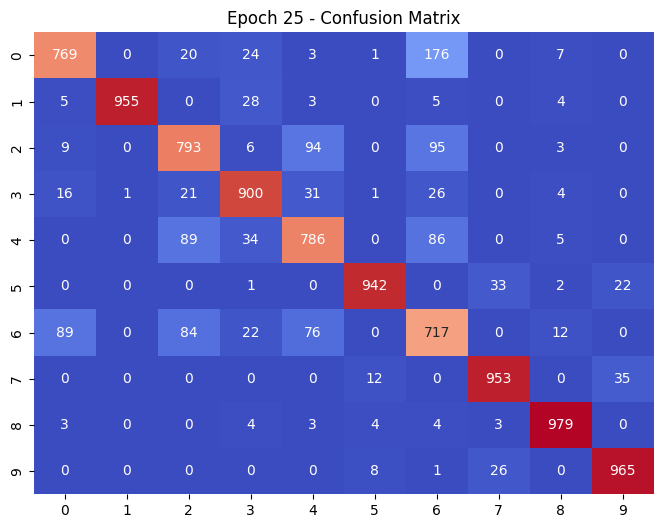

In [46]:
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(8, 6))
ims = []

nn = NeuralNetwork(
    input_size=784,
    hidden_layers=6,
    hidden_neurons=128,
    output_size=10,
    activation='ReLU',
    optimizer='nadam',
    weight_init='random',
    learning_rate=0.001,
    l2_reg=0
)

# Train the model and log metrics
for epoch in range(25):
    train_loss, train_acc = nn.train(X_train, y_train, batch_size=32)
    val_loss, val_acc = nn.evaluate(X_val, y_val)
    y_pred_labels, y_true_labels = nn.test(X_test, y_test)
    acc = accuracy_score(y_true_labels, y_pred_labels)
    cm = confusion_matrix(y_true_labels, y_pred_labels)

    ax.clear()
    im = sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", cbar=False, ax=ax)
    ax.set_title(f"Epoch {epoch+1} - Confusion Matrix")
    ims.append([ax.collections[0]])
    
    print('Epoch: {}, Accuracy: {:.2f}, Loss: {:.2f}'.format(epoch, val_acc, val_loss))
    print(f"Test Accuracy: {acc * 100:.2f}%")


In [56]:
y_pred_labels, y_true_labels = nn.test(X_test, y_test)
acc = accuracy_score(y_true_labels, y_pred_labels)
cm = confusion_matrix(y_true_labels, y_pred_labels)

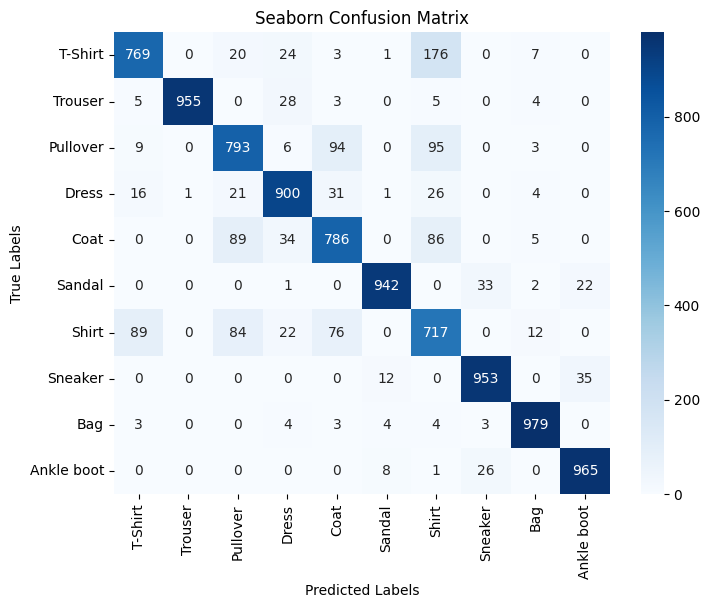

<Figure size 640x480 with 0 Axes>

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix_seaborn_from_predictions(y_true_labels, y_pred_labels, classes, title='Confusion Matrix'):
    """
    Plots a confusion matrix using seaborn from provided true and predicted labels.
    """
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

class_names = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']  # Replace with your actual class names

# Plotting using seaborn:
plot_confusion_matrix_seaborn_from_predictions(y_true_labels, y_pred_labels, classes=class_names, title='Seaborn Confusion Matrix')
wandb.log({"Best Model Confusion Heatmap": wandb.Image(plt)})
wandb.log({"Best Model Confusion Matrix": wandb.plot.confusion_matrix(probs=None, y_true=y_true_labels, preds=y_pred_labels)})
